# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
!pip install kmodes

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import KElbowVisualizer
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
# from sklearn_extra.cluster import KMedoids

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [3]:
# Load dataset
customers = pd.read_csv("Customers.csv")
customers.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [4]:
# 1. Memahami Struktur Data
# - Jumlah baris dan kolom dalam dataset
rows, columns = customers.shape
print(f"Rows: {rows}, Columns: {columns}")

# - Melihat jenis data
print(customers.dtypes)

Rows: 2000, Columns: 8
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income ($)          int64
Spending Score (1-100)     int64
Profession                object
Work Experience            int64
Family Size                int64
dtype: object


In [5]:
# 2. Identifikasi dan analisis data yang hilang
missing_values = customers.isnull().sum()
missing_values[missing_values > 0]

,0
Profession,35


In [6]:
# 3. Analisis distribusi dan korelasi

# - Menampilkan statistik deskriptif
customers.describe(include="all")

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
count,2000.000000,2000,2000.000000,2000.000000,2000.000000,1965,2000.000000,2000.000000
unique,NaN,2,NaN,NaN,NaN,9,NaN,NaN
top,NaN,Female,NaN,NaN,NaN,Artist,NaN,NaN
freq,NaN,1186,NaN,NaN,NaN,612,NaN,NaN
mean,1000.500000,NaN,48.960000,110731.821500,50.962500,NaN,4.102500,3.768500
std,577.494589,NaN,28.429747,45739.536688,27.934661,NaN,3.922204,1.970749
min,1.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,1.000000
25%,500.750000,NaN,25.000000,74572.000000,28.000000,NaN,1.000000,2.000000
50%,1000.500000,NaN,48.000000,110045.000000,50.000000,NaN,3.000000,4.000000
75%,1500.250000,NaN,73.000000,149092.750000,75.000000,NaN,7.000000,5.000000


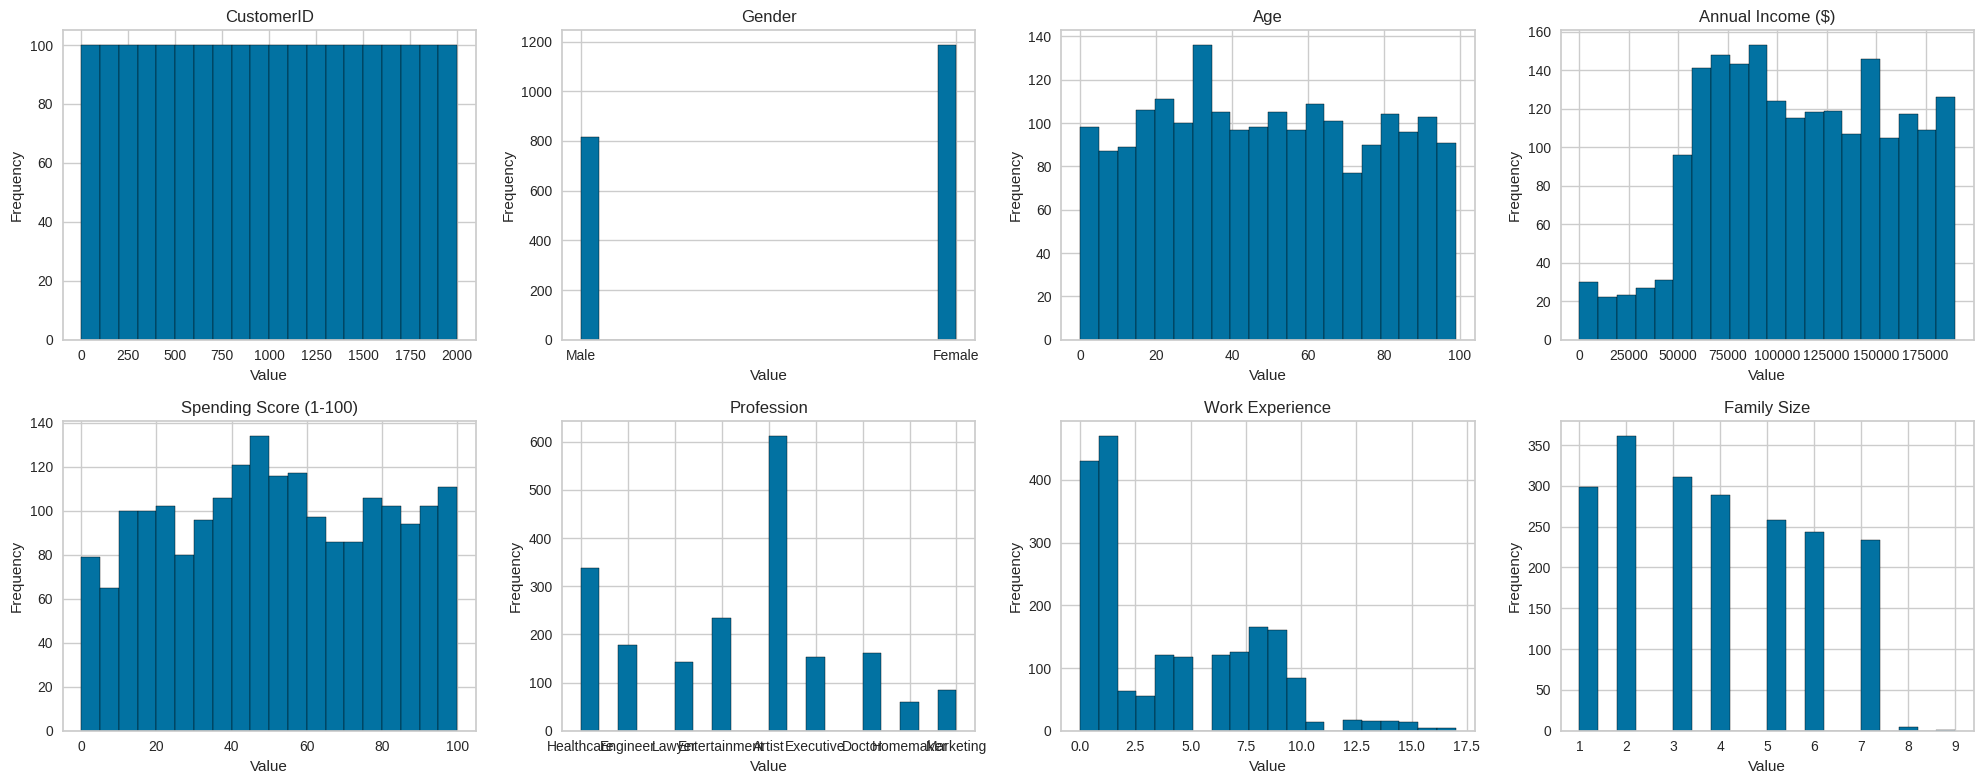

In [7]:
# - Melihat distribusi data menggunakan histogram
num_vars = customers.shape[1]
n_cols = 4
n_rows = -(-num_vars // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(customers.columns):
    customers[column].hist(ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

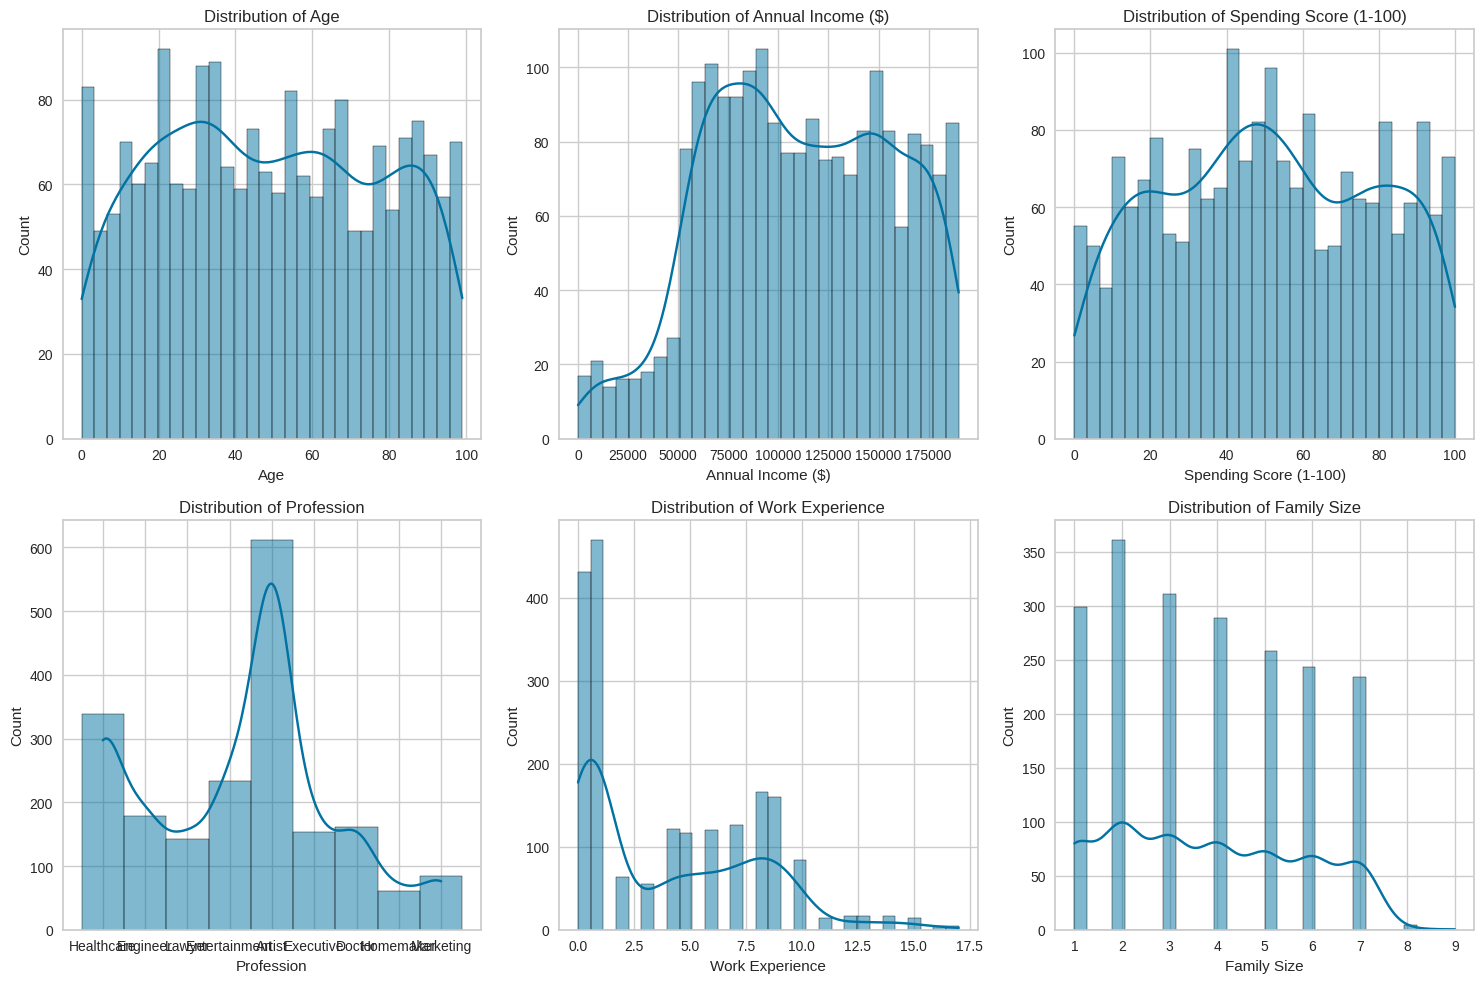

In [8]:
# - Melihat korelasi antara variabel numerik
columns_to_plot = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Profession', 'Work Experience', 'Family Size']

plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(customers[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

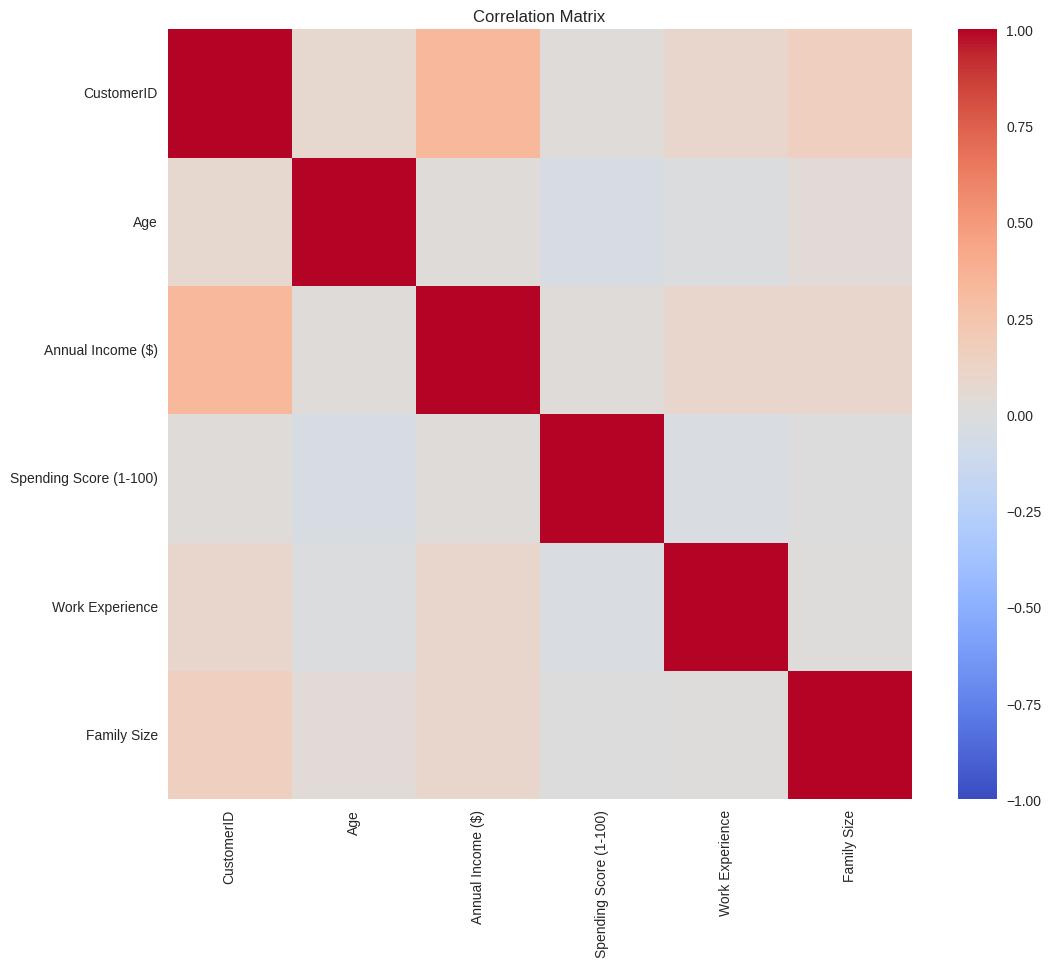

In [9]:
# - Memeriksa hubungan antara variabel menggunakan matriks korelasi
plt.figure(figsize=(12, 10))
numerical_fields = customers.select_dtypes(include=['number'])
correlation_matrix = numerical_fields.corr()

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [10]:
# 1. Menangani Missing Values
# Karena hanya terdapat 35 missing values pada kolom Profession, maka akan digunakan
# teknik pengambilan modus (data yang paling banyak muncul)

df = customers.copy()
df['Profession'] = df['Profession'].fillna(df['Profession'].mode()[0])
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

,0


In [11]:
# 2. Menghapus data duplikat

# Cek duplikasi data
duplicates = df.duplicated()

print("Baris duplikat:")
print(df[duplicates])

Baris duplikat:
Empty DataFrame
Columns: [CustomerID, Gender, Age, Annual Income ($), Spending Score (1-100), Profession, Work Experience, Family Size]
Index: []


In [12]:
# 3. Normalisasi fitur
scaler = MinMaxScaler()
df[numerical_fields.columns] = scaler.fit_transform(df[numerical_fields.columns])

Text(0.5, 1.0, 'Histogram Sebelum Normalisasi')

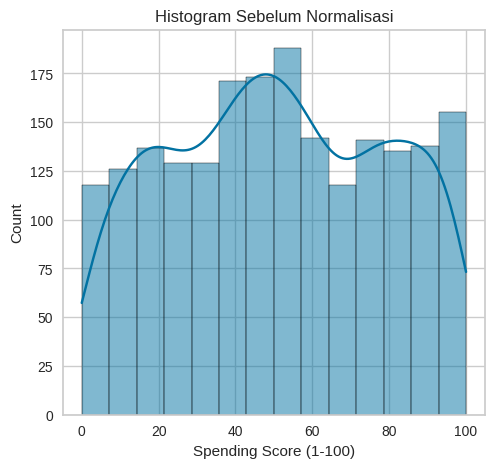

In [13]:
# Histogram Sebelum Normalisasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(customers[numerical_fields.columns[3]], kde=True)
plt.title("Histogram Sebelum Normalisasi")

Text(0.5, 1.0, 'Histogram Setelah Normalisasi')

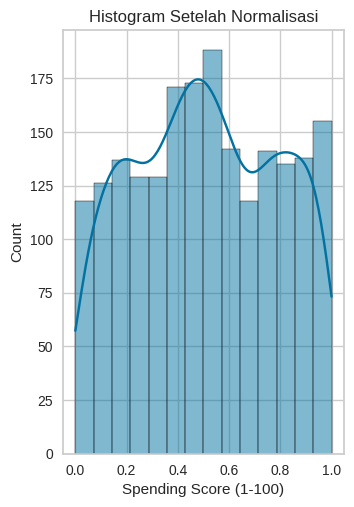

In [14]:
# Histogram Setelah Normalisasi
plt.subplot(1, 2, 2)
sns.histplot(df[numerical_fields.columns[3]], kde=True)
plt.title("Histogram Setelah Normalisasi")

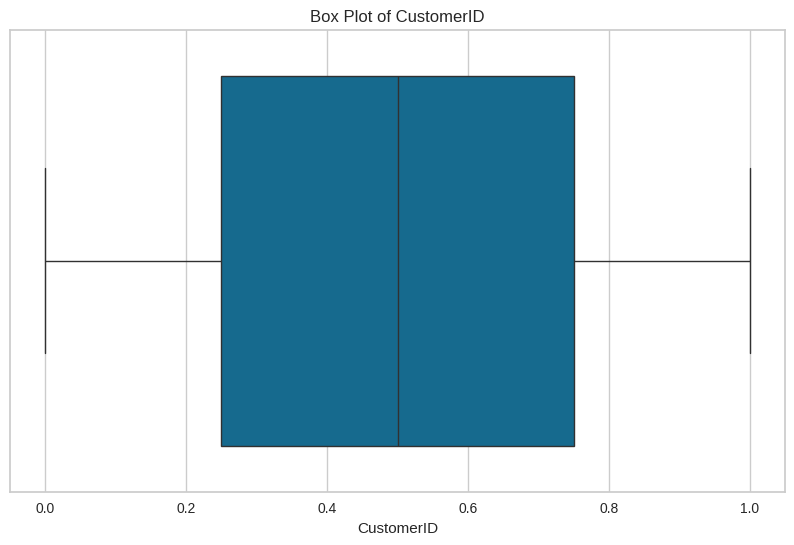

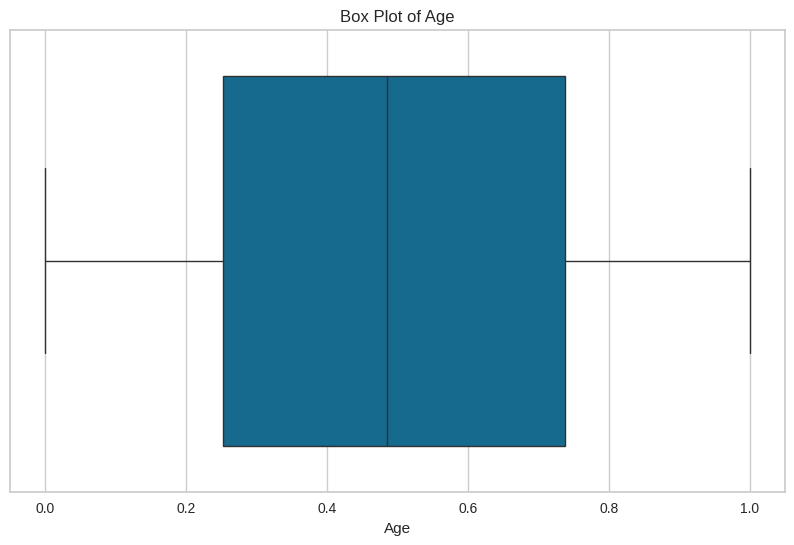

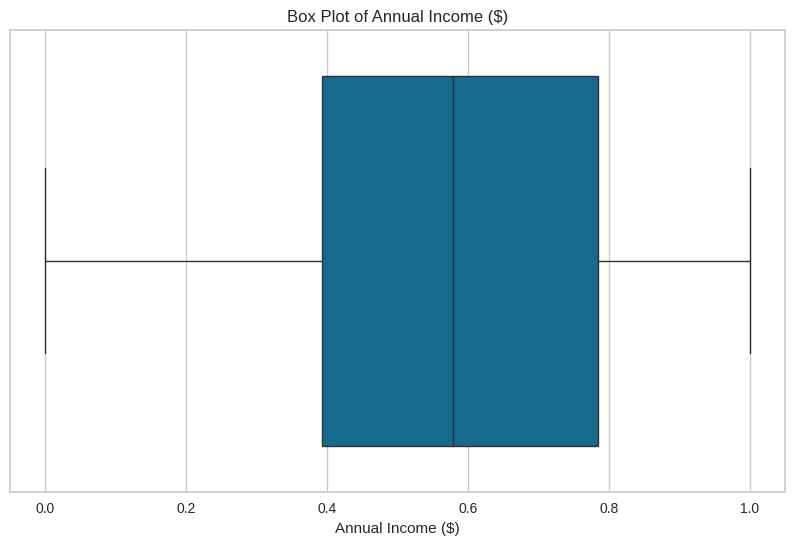

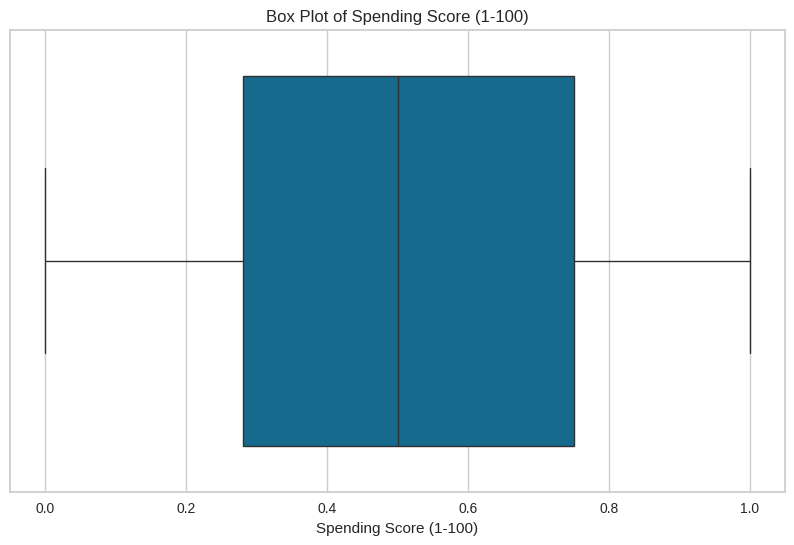

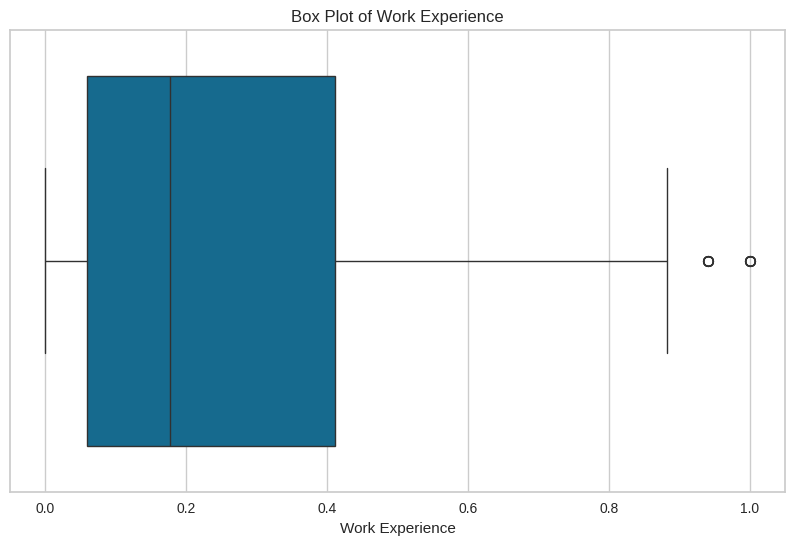

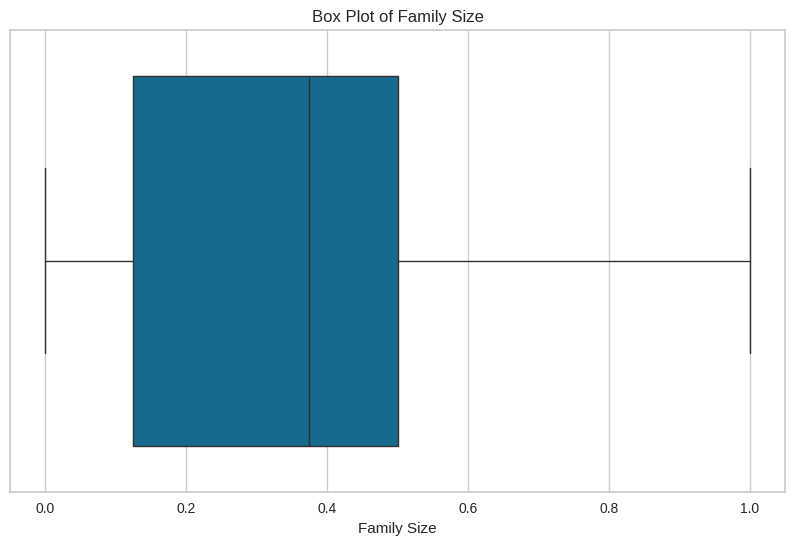

In [15]:
# 4. Deteksi dan Penanganan Outlier

# Periksa keberadaan outlier
for feature in numerical_fields.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

In [16]:
# Identifikasi outliers dengan IQR
Q1 = df[numerical_fields.columns].quantile(0.25)
Q3 = df[numerical_fields.columns].quantile(0.75)
IQR = Q3 - Q1

# Simpan baris yang tidak mengandung outlier
condition = ~((df[numerical_fields.columns] < (Q1 - 1.5 * IQR)) | (df[numerical_fields.columns] > (Q3 + 1.5 * IQR))).any(axis=1)
df_filtered_numeric = df.loc[condition, numerical_fields.columns]

# Merge dengan kolom non-numerik
categorical_features = df.select_dtypes(include=['object']).columns
df = pd.concat([df_filtered_numeric, df.loc[condition, categorical_features]], axis=1)

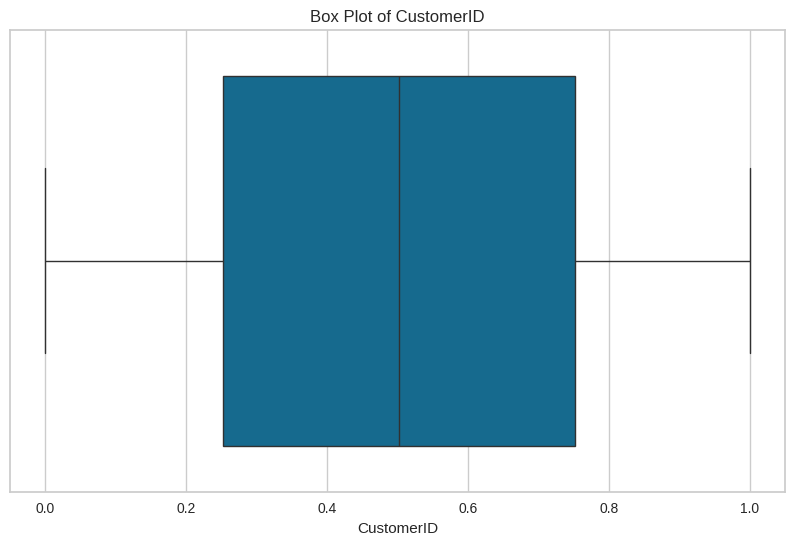

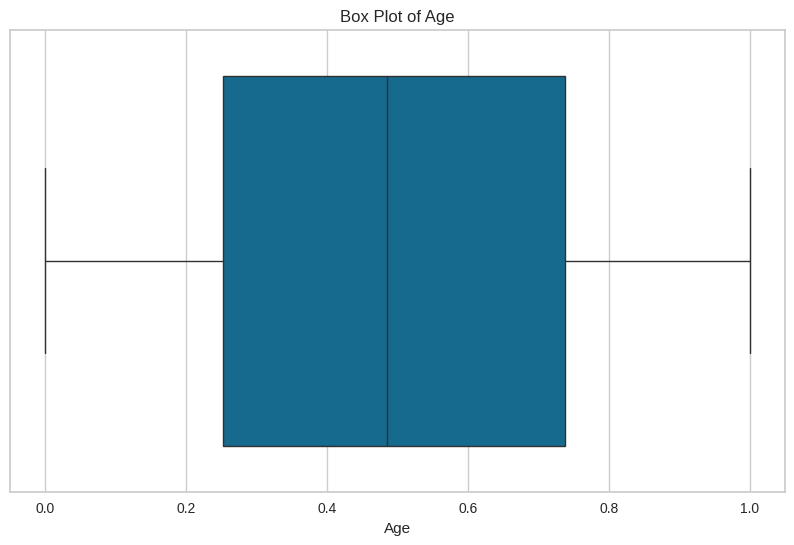

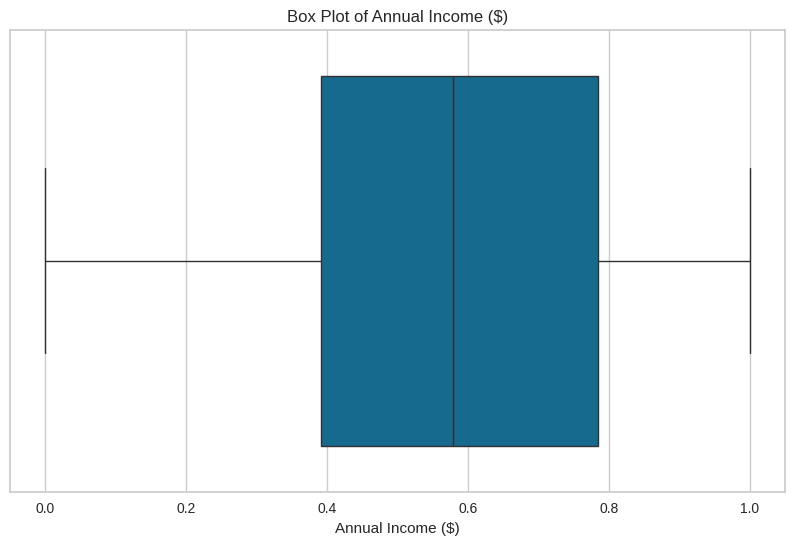

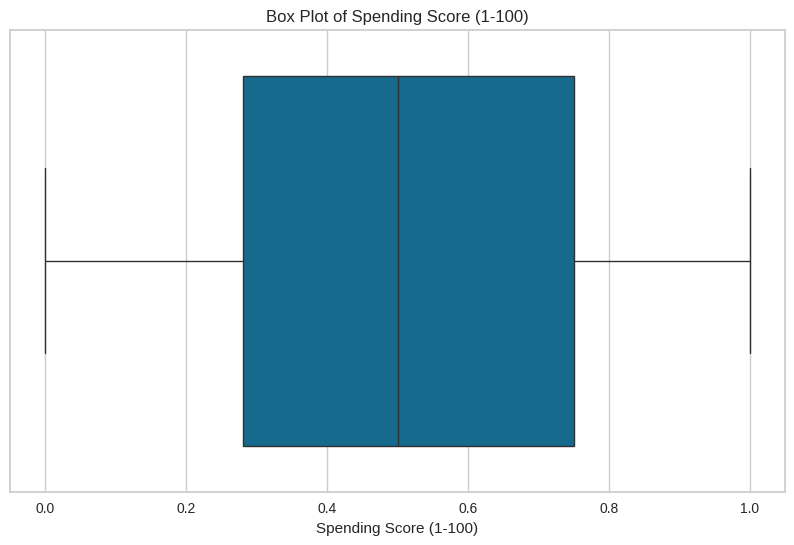

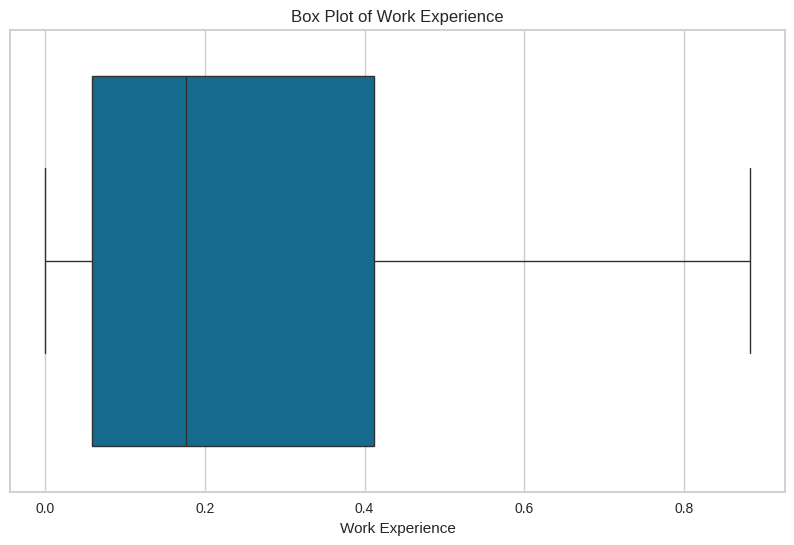

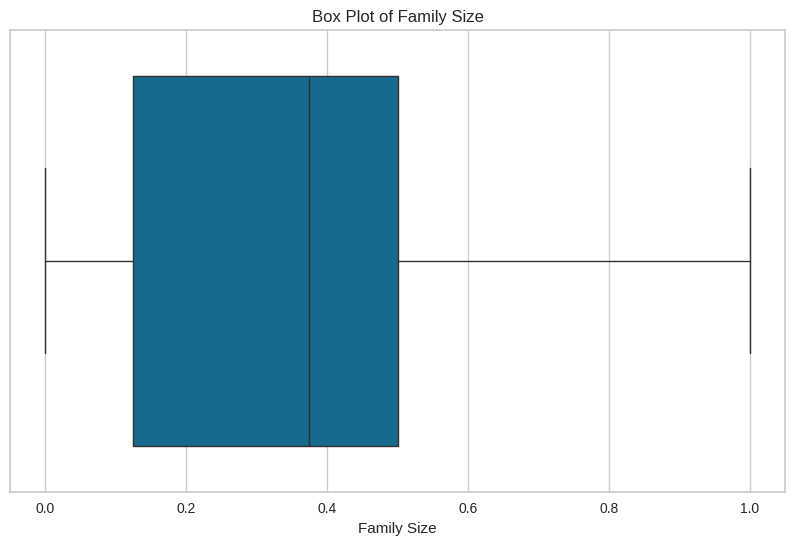

In [17]:
# Bandingkan Visualisasi Data Setelah Outliers Ditangani
for feature in df_filtered_numeric:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

In [18]:
# 5. Encoding Data Kategorikal

# Label Encoding dipilih karena kolom kategorikal bukan merupakan data ordinal
# df_one_hot = pd.get_dummies(df, columns=categorical_features)
# df_one_hot

label_encoder = LabelEncoder()
df_lencoder = pd.DataFrame(df)

for col in categorical_features:
    df_lencoder[col] = label_encoder.fit_transform(df[col])

# Menampilkan hasil
df_lencoder

,CustomerID,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size,Gender,Profession
0,0.000000,0.191919,0.078958,0.39,0.058824,0.375,1,5
1,0.000500,0.212121,0.184236,0.81,0.176471,0.250,1,2
2,0.001001,0.202020,0.452694,0.06,0.058824,0.000,0,2
3,0.001501,0.232323,0.310569,0.77,0.000000,0.125,0,7
4,0.002001,0.313131,0.200027,0.40,0.117647,0.625,0,3
...,...,...,...,...,...,...,...,...
1995,0.997999,0.717172,0.970591,0.40,0.470588,0.750,0,0
1996,0.998499,0.919192,0.385095,0.32,0.411765,0.750,0,1
1997,0.998999,0.878788,0.478808,0.14,0.529412,0.125,1,5
1998,0.999500,0.777778,0.958600,0.04,0.411765,0.125,1,4


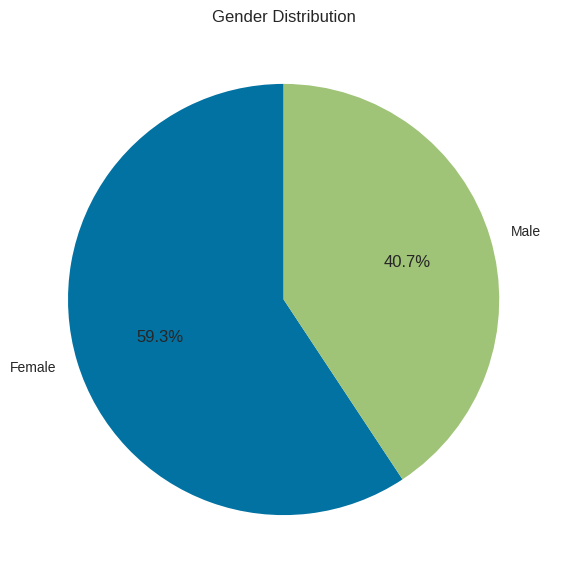

In [19]:
# 6. Pengelompokkan Data (Binning)

# Melihat rasio perbandingan antara laki-laki dan perempuan
plt.figure(figsize=(7, 7))
plt.pie(df['Gender'].value_counts(), labels=['Female', 'Male'], autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.show()

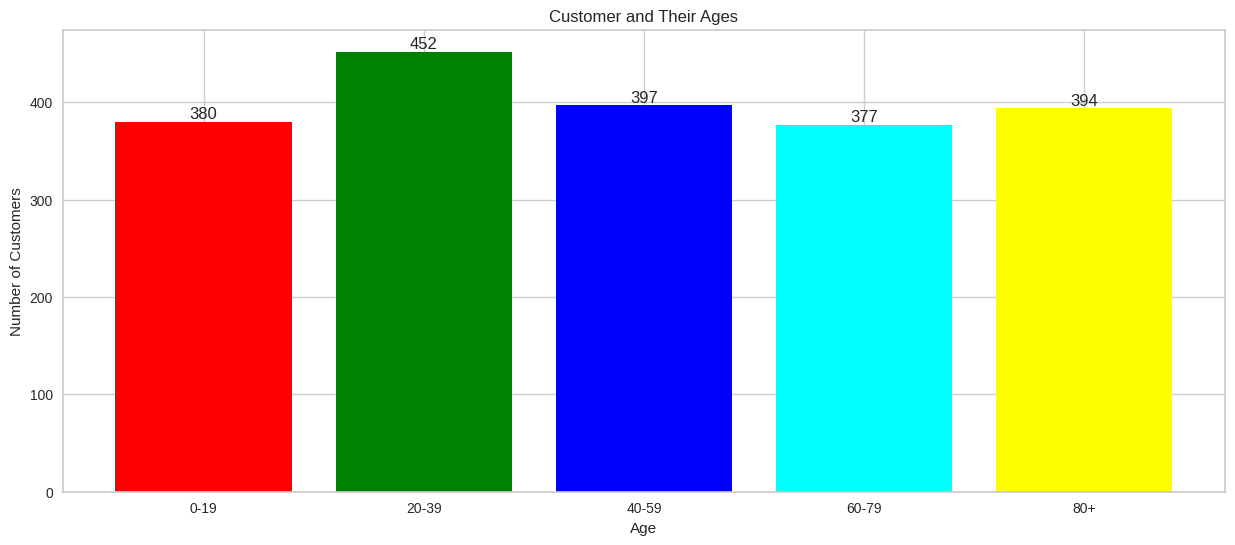

In [20]:
# Groupping data by Age
age0_19 = customers.Age[(customers.Age >= 0) & (customers.Age <= 19)]
age20_39 = customers.Age[(customers.Age >= 20) & (customers.Age <= 39)]
age40_59 = customers.Age[(customers.Age >= 40) & (customers.Age <= 59)]
age60_79 = customers.Age[(customers.Age >= 60) & (customers.Age <= 79)]
age80above = customers.Age[customers.Age >= 80]

# Menyusun data untuk plotting
x = ["0-19", "20-39", "40-59", "60-79", "80+"]
y = [len(age0_19.values), len(age20_39.values), len(age40_59.values), len(age60_79.values), len(age80above.values)]

# Membuat bar chart untuk distribusi usia pelanggan
plt.figure(figsize=(15, 6))
plt.bar(x, y, color=['red', 'green', 'blue', 'cyan', 'yellow'])
plt.title("Customer and Their Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customers")

# Menambahkan label jumlah pelanggan di atas setiap bar
for i in range(len(x)):
  plt.text(i, y[i], y[i], ha='center', va='bottom')

plt.show()

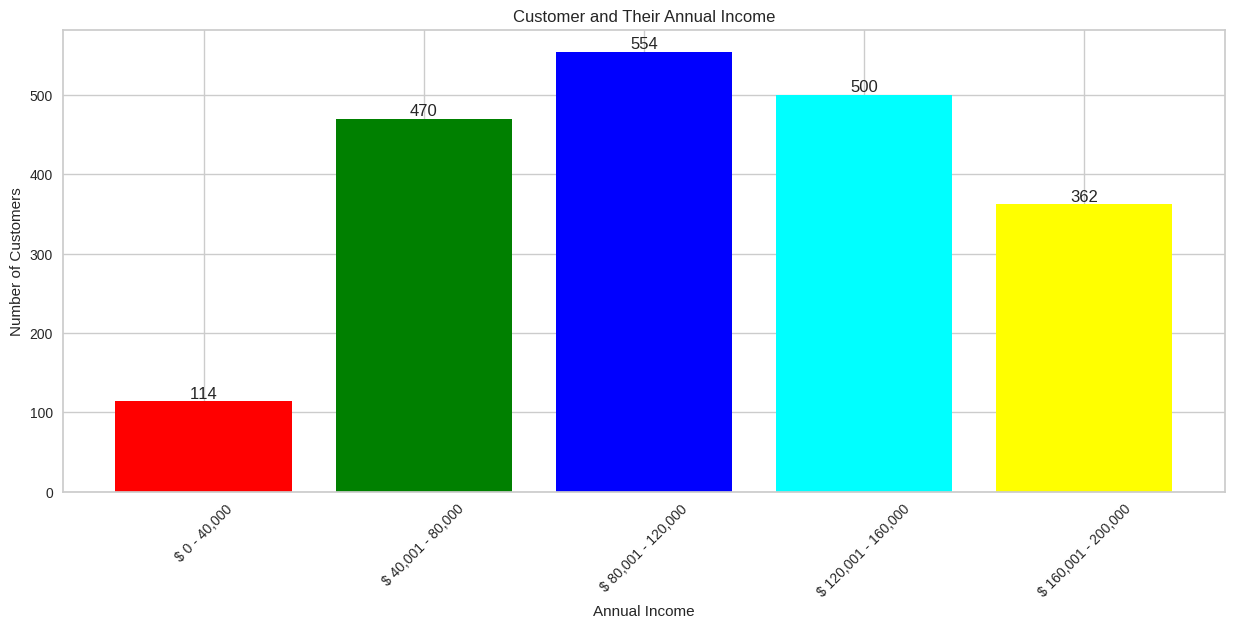

In [21]:
# Mengelompokkan pendapatan tahunan pelanggan ke dalam kategori dan menghitung jumlah pelanggan di setiap kategori
ai0_40 = customers["Annual Income ($)"][(customers["Annual Income ($)"] >= 0) & (customers["Annual Income ($)"] <= 40000)]
ai41_80 = customers["Annual Income ($)"][(customers["Annual Income ($)"] >= 40001) & (customers["Annual Income ($)"] <= 80000)]
ai81_120 = customers["Annual Income ($)"][(customers["Annual Income ($)"] >= 80001) & (customers["Annual Income ($)"] <= 120000)]
ai121_160 = customers["Annual Income ($)"][(customers["Annual Income ($)"] >= 120001) & (customers["Annual Income ($)"] <= 160000)]
ai161_200 = customers["Annual Income ($)"][(customers["Annual Income ($)"] >= 160001) & (customers["Annual Income ($)"] <= 200000)]

# Menyusun data untuk plotting
aix = ["$ 0 - 40,000", "$ 40,001 - 80,000", "$ 80,001 - 120,000", "$ 120,001 - 160,000", "$ 160,001 - 200,000"]
aiy = [len(ai0_40.values), len(ai41_80.values), len(ai81_120.values), len(ai121_160.values), len(ai161_200.values)]

# Membuat bar chart untuk distribusi pendapatan tahunan pelanggan
plt.figure(figsize=(15, 6))
plt.bar(aix, aiy, color=['red', 'green', 'blue', 'cyan', 'yellow'])
plt.title("Customer and Their Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)  # Memutar label sumbu x agar lebih mudah dibaca

# Menambahkan label jumlah pelanggan di atas setiap bar
for i in range(len(aix)):
  plt.text(i, aiy[i], aiy[i], ha='center', va='bottom')

plt.show()

In [22]:
# Mengambil kolom 'Annual Income', 'Spending Score', dan 'Profession' dari dataset dan menyimpannya dalam array X
X = df_lencoder.iloc[:, [3, 6]].values

# Menampilkan data yang diambil dalam format DataFrame dengan nama kolom yang sesuai
print(pd.DataFrame(X, columns=['Spending Score', 'Gender']))

      Spending Score  Gender
0               0.39     1.0
1               0.81     1.0
2               0.06     0.0
3               0.77     0.0
4               0.40     0.0
...              ...     ...
1985            0.40     0.0
1986            0.32     0.0
1987            0.14     1.0
1988            0.04     1.0
1989            0.52     1.0

[1990 rows x 2 columns]


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [26]:
# Mendapatkan jumlah cluster
k = 6

km = KPrototypes(n_clusters=k, init='random', n_init=5, verbose=1)
km.fit(X, categorical=[1])
labels = km.labels_

# Fungsi untuk analisis karakteristik cluster
def analyze_clusters(X, labels, k, num_features):
    print("Analisis Karakteristik Setiap Cluster:")
    for cluster_id in range(k):
        # Mengambil data untuk cluster saat ini
        cluster_data = X[labels == cluster_id]

        # Menghitung rata-rata untuk setiap fitur dalam cluster
        # mean_age = cluster_data[:, 0].mean()  # Rata-rata Age
        # mean_income = cluster_data[:, 1].mean()  # Rata-rata Annual
        mean_spending = cluster_data[:, 0].mean()  # Rata-rata spending
        mean_gender = cluster_data[:, 1].mean()  # Rata-rata profession
        # mean_profession = cluster_data[:, 3].mean()  # Rata-rata profession

        dummy_array = [[0] * num_features]
        dummy_array[0][numerical_fields.columns.get_loc('Spending Score (1-100)')] = mean_spending
        mean_original = scaler.inverse_transform(dummy_array)[0][numerical_fields.columns.get_loc('Spending Score (1-100)')]

        print(f"\nCluster {cluster_id + 1}:")
        # print(f"Rata-rata Age: {mean_age:.2f}")
        # print(f"Rata-rata Annual Income (Normalize): {mean_income:.2f}")
        # print(f"Rata-rata Annual Income (Original): {mean_original:.2f}")
        print(f"Rata-rata Spending Score (Normalize): {mean_spending:.2f}")
        print(f"Rata-rata Spending Score (Original): {mean_original:.2f}")
        # print(f"Rata-rata Work Experience: {mean_work:.2f}")
        print(f"Rata-rata Gender: {mean_gender:.2f}")

# Jumlah kolom numerik dan kategorikal
num_features = len(numerical_fields.columns)
# Analisis karakteristik setiap cluster
analyze_clusters(X, labels, k, num_features)

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 533, ncost: 28.640407054293767
Run: 1, iteration: 2/100, moves: 191, ncost: 25.474026554396026
Run: 1, iteration: 3/100, moves: 101, ncost: 24.728628407983372
Run: 1, iteration: 4/100, moves: 59, ncost: 24.50498044896374
Run: 1, iteration: 5/100, moves: 48, ncost: 24.357605954053852
Run: 1, iteration: 6/100, moves: 29, ncost: 24.281994277808586
Run: 1, iteration: 7/100, moves: 41, ncost: 24.183313001495833
Run: 1, iteration: 8/100, moves: 25, ncost: 24.132372285364614
Run: 1, iteration: 9/100, moves: 26, ncost: 24.087209869124596
Run: 1, iteration: 10/100, moves: 21, ncost: 24.04149990476307
Run: 1, iteration: 11/100, moves: 29, ncost: 23.992531710299563
Run: 1, iteration: 12/100, moves: 4, ncost: 23.991084039055448
Run: 1, iteration: 13/100, moves: 0, ncost: 23.991084039055448
Init: initializing centroids
Init: initia

## **b. Evaluasi Model Clustering**

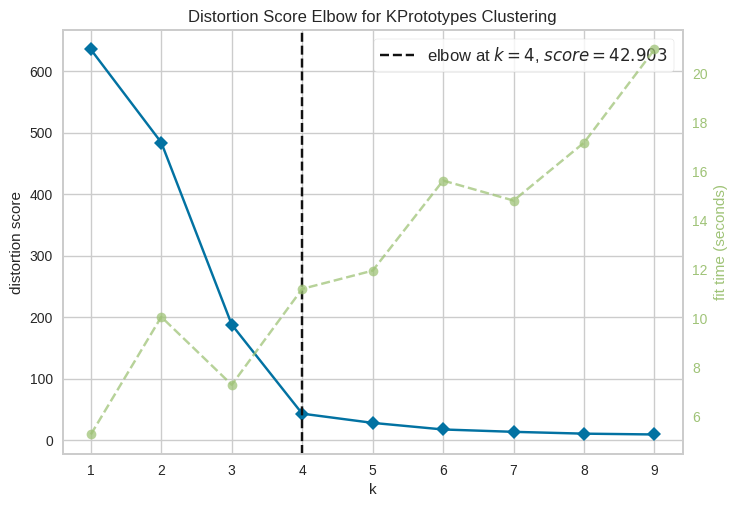

<Axes: title={'center': 'Distortion Score Elbow for KPrototypes Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Inisialisasi model tanpa parameter awal
km = KPrototypes()

# Inisialisasi visualizer KElbow untuk menentukan jumlah cluster optimal
visualizer = KElbowVisualizer(km, k=(1, 10))

# Fit visualizer dengan data untuk menemukan jumlah cluster optimal
visualizer.fit(X, categorical=[1])

# Menampilkan grafik elbow untuk analisis
visualizer.show()

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [27]:
# Periksa Silhouette Score
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6042429961184839


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [28]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

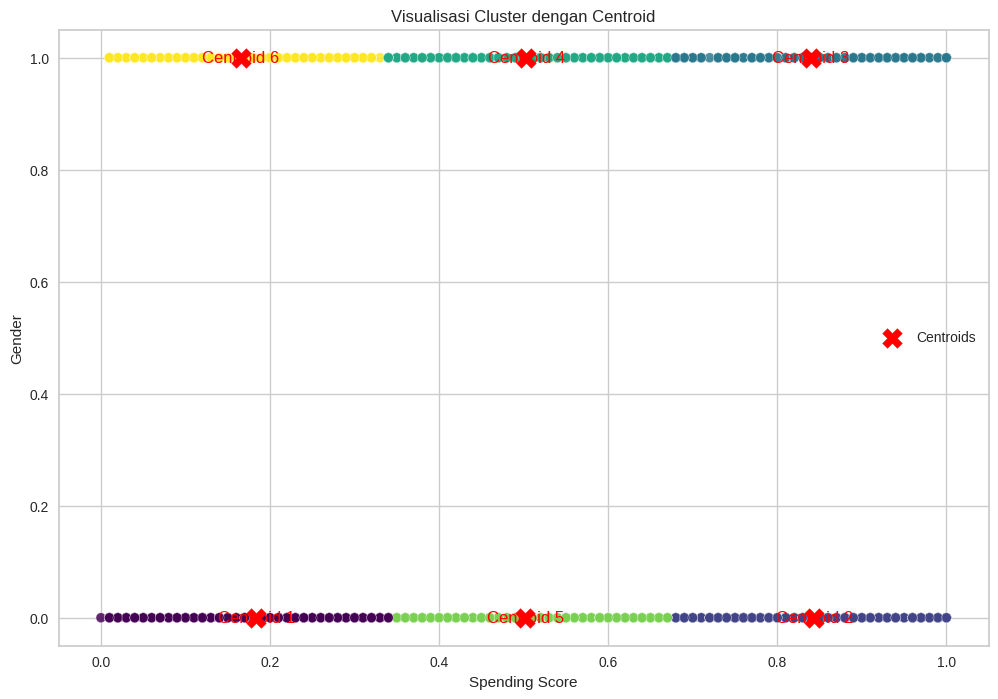

Nilai Centroids:
Centroid 1: Spending Score = 0.18, Gender = 0.00
Centroid 2: Spending Score = 0.84, Gender = 0.00
Centroid 3: Spending Score = 0.84, Gender = 1.00
Centroid 4: Spending Score = 0.50, Gender = 1.00
Centroid 5: Spending Score = 0.50, Gender = 0.00
Centroid 6: Spending Score = 0.17, Gender = 1.00


In [29]:
# Visualisais Hasil CLustering Menggunakan Scatter Plot

# Menentukan posisi centroid
centroids = km.cluster_centroids_

# Visualisasi cluster
plt.figure(figsize=(12, 8))

# Plot data
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6, edgecolors='w', marker='o')

# Plot centroid
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')

# Menambahkan label centroid pada plot
for i, centroid in enumerate(centroids):
    plt.text(centroid[0], centroid[1], f'Centroid {i+1}', color='red', fontsize=12, ha='center', va='center')

# Menambahkan judul dan label
plt.title('Visualisasi Cluster dengan Centroid')
plt.xlabel('Spending Score')
plt.ylabel('Gender')
plt.legend()

plt.show()

# Menampilkan nilai centroid
print("Nilai Centroids:")
for i, centroid in enumerate(centroids):
    print(f"Centroid {i+1}: Spending Score = {centroid[0]:.2f}, Gender = {centroid[1]:.2f}")

## **e. Analisis dan Interpretasi Hasil Cluster**



Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [30]:
# Inverse Normalization
df[numerical_fields.columns] = scaler.inverse_transform(df[numerical_fields.columns])

# Kembalikan tipe data ke integer
for col in numerical_fields.columns:
    df[col] = df[col].astype(int)

df.head()

,CustomerID,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size,Gender,Profession
0,1,19,15000,39,1,4,Male,Healthcare
1,2,21,35000,81,2,3,Male,Engineer
2,3,20,86000,6,1,1,Female,Engineer
3,4,23,59000,77,0,2,Female,Lawyer
4,5,31,38000,40,2,6,Female,Entertainment


In [31]:
# Menampilkan statistik deskriptif hasil cluster
cluster_data = []
for cluster_id in range(k):
    cluster_data.append(df[labels == cluster_id])

for i, cluster in enumerate(cluster_data):
    print(f"\nCluster {i + 1}:")
    print(cluster.describe(include="all"))


Cluster 1:
         CustomerID         Age  Annual Income ($)  Spending Score (1-100)  \
count    373.000000  373.000000         373.000000              373.000000   
unique          NaN         NaN                NaN                     NaN   
top             NaN         NaN                NaN                     NaN   
freq            NaN         NaN                NaN                     NaN   
mean     985.235925   47.884718      107792.415550               18.337802   
std      555.861037   28.139249       46684.605906                9.752507   
min        3.000000    0.000000        3000.000000                0.000000   
25%      507.000000   25.000000       69024.000000               10.000000   
50%      951.000000   46.000000      103838.000000               19.000000   
75%     1488.000000   73.000000      148594.000000               27.000000   
max     1997.000000   98.000000      189672.000000               34.000000   

        Work Experience  Family Size  Gender Profes

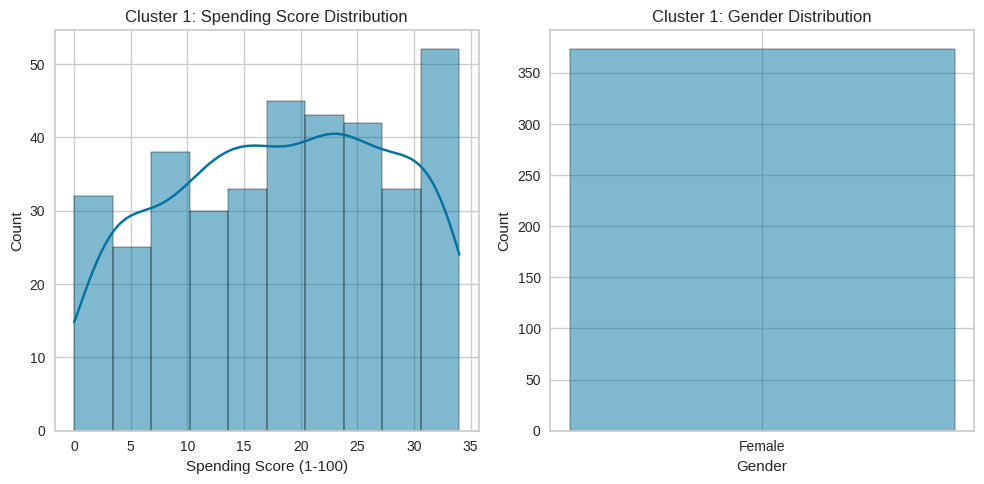

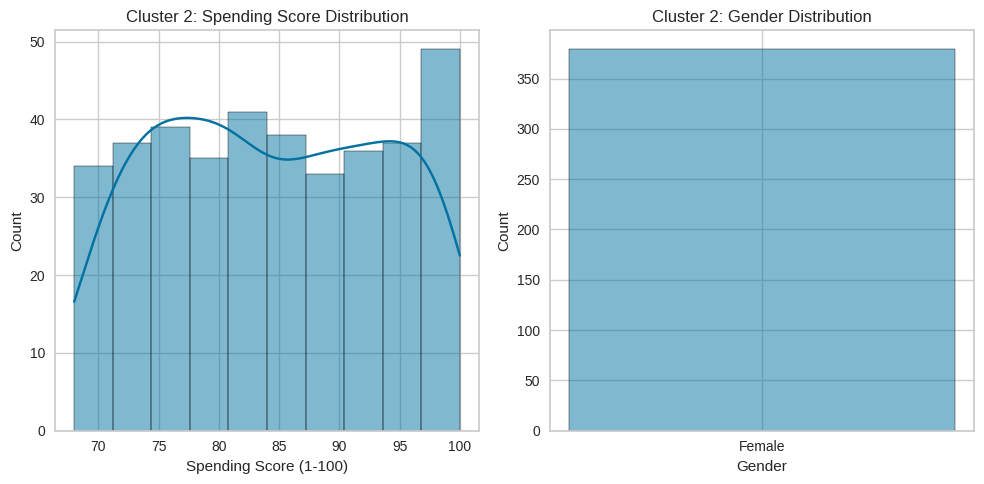

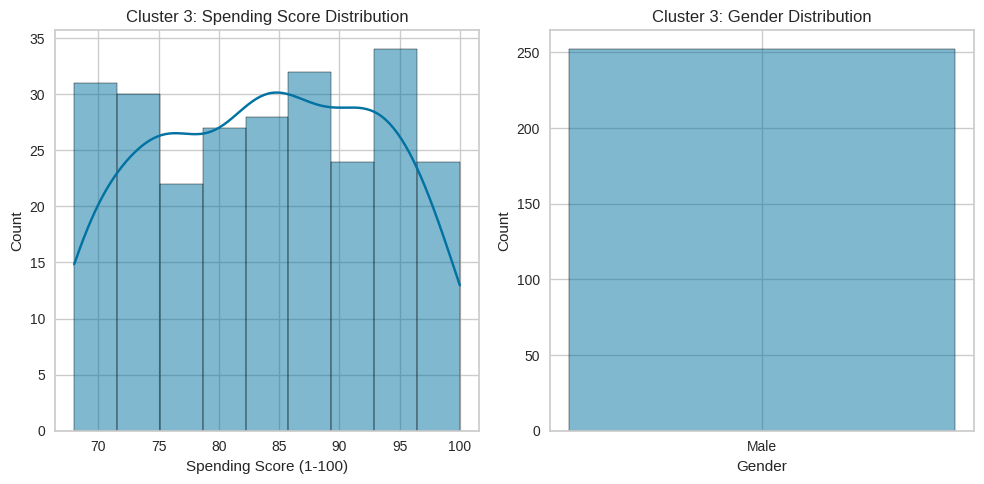

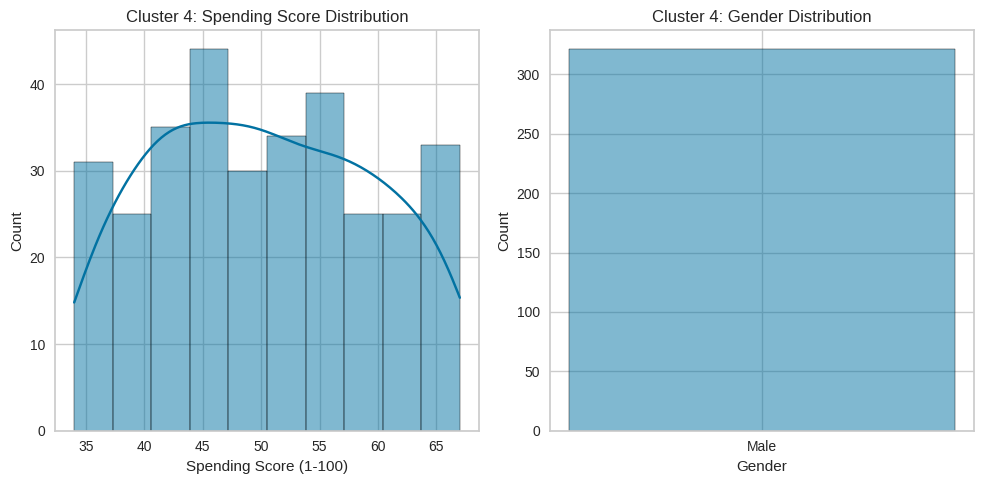

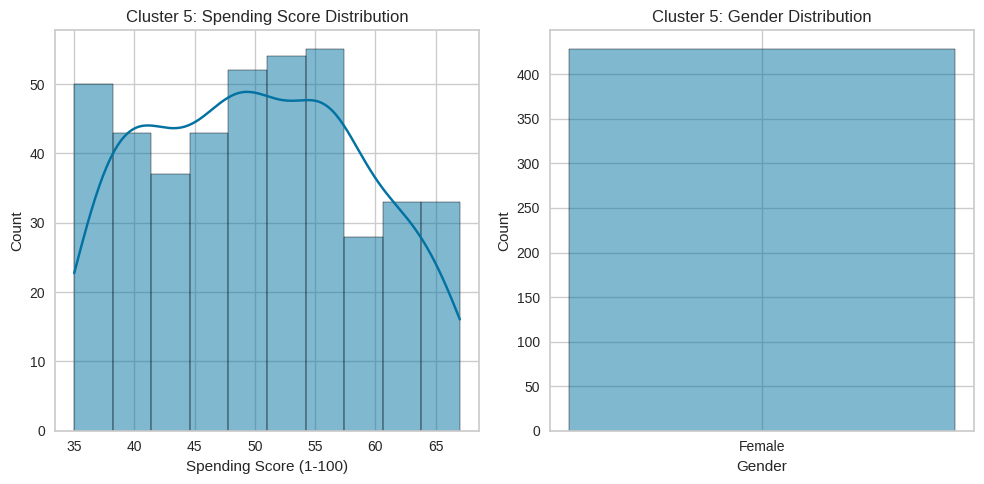

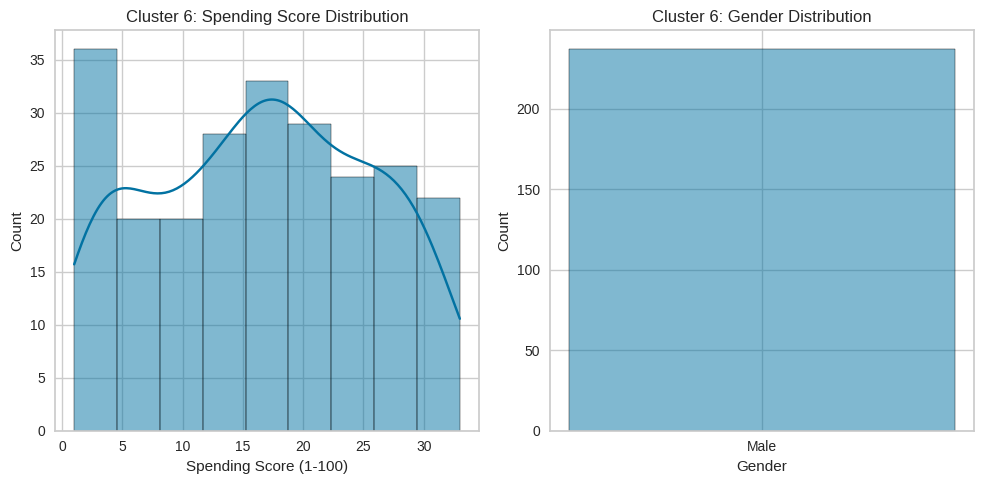

In [32]:
# Visualisasi distribusi fitur antar cluster
for i, cluster in enumerate(cluster_data):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(cluster['Spending Score (1-100)'], kde=True)
    plt.title(f'Cluster {i + 1}: Spending Score Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(cluster['Gender'], kde=True)
    plt.title(f'Cluster {i + 1}: Gender Distribution')

    plt.tight_layout()
    plt.show()

Tulis hasil interpretasinya di sini.
1. Cluster 1:
- Memiliki rata-rata spending score sebesar 0.18 (nilai asli berkisar 18.36) dan nilai rata-rata gender 0.00 (Female)
- Menunjukkan jumlah spending score terendah dibanding kedua cluster lainnya yang mempunyai gender sejenis (Female)
- Merupakan kelompok pelanggan wanita yang memiliki tingkat pengeluaran rendah.

2. Cluster 2:
- Memiliki rata-rata spending score sebesar 0.84 (nilai asli berkisar 84.39) dan nilai rata-rata gender 0.00 (Female)
- Menunjukkan jumlah spending score tertinggi dibanding kedua cluster lainnya yang mempunyai gender sejenis (Female)
- Merupakan kelompok pelanggan wanita yang memiliki tingkat pengeluaran tinggi.

3. Cluster 3:
- Memiliki rata-rata spending score sebesar 0.84 (nilai asli berkisar 83.96) dan nilai rata-rata gender 1.00 (Male)
- Menunjukkan jumlah spending score tertinggi dibanding kedua cluster lainnya yang mempunyai gender sejenis (Male)
- Merupakan kelompok pelanggan pria yang memiliki tingkat pengeluaran tinggi.

4. Cluster 4:
- Memiliki rata-rata spending score sebesar 0.50 (nilai asli berkisar 50.33) dan nilai rata-rata gender 1.00 (Male)
- Menunjukkan jumlah spending score menengah dibanding kedua cluster lainnya yang mempunyai gender sejenis (Male)
- Merupakan kelompok pelanggan pria yang memiliki tingkat pengeluaran menengah.

5. Cluster 5:
- Memiliki rata-rata spending score sebesar 0.50 (nilai asli berkisar 50.18) dan nilai rata-rata gender 0.00 (Female)
- Menunjukkan jumlah spending score menengah dibanding kedua cluster lainnya yang mempunyai gender sejenis (Female)
- Merupakan kelompok pelanggan wanita yang memiliki tingkat pengeluaran menengah.

6. Cluster 6:
- Memiliki rata-rata spending score sebesar 0.17 (nilai asli berkisar 16.51) dan nilai rata-rata gender 1.00 (Male)
- Menunjukkan jumlah spending score terendah dibanding kedua cluster lainnya yang mempunyai gender sejenis (Male)
- Merupakan kelompok pelanggan pria yang memiliki tingkat pengeluaran rendah.

Kesimpulan:
- Keenam cluster dapat dibagi menjadi 2 kelompok besar, yakni berdasarkan gender (Male dan Female). Pada kedua kelompok tersebut, terdapat 3 data yang masing-masing mewakili spending score tertinggi, menengah, dan terendah.
- Secara keseluruhan, spending score tertinggi terdapat pada cluster 2 dan spending score terendah terdapat pada cluster 6.
- Jika dilihat pada hasil statistik deskriptif, tampak bahwa pelanggan terbanyak termasuk dalam cluster 5, yaitu pelanggan wanita dengan tingkat pengeluaran menengah, yang muncul sebanyak 428 kali. Sedangkan kelompok pelanggan yang paling sedikit adalah cluster 6, yakni pelanggan pria dengan tingkat pengeluaran rendah, yang muncul sebanyak 237 kali.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [33]:
df_lencoder['Cluster'] = labels
df_lencoder.to_csv('clustered_data.csv', index=False)